# 406 GAN

View more, visit my tutorial page: https://mofanpy.com/tutorials/
My Youtube Channel: https://www.youtube.com/user/MorvanZhou

Dependencies:
* torch: 0.1.11
* numpy
* matplotlib

Note: Below cells only work for pytorch version lower than 1.5, if you are using pytorch 1.5 or higher, then you will get in place error when you run For loop for Step(10000). Fixed version has been added below.

In [3]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

torch.manual_seed(1)    # reproducible
np.random.seed(1)

In [2]:
# Hyper Parameters
BATCH_SIZE = 64
LR_G = 0.0001           # learning rate for generator
LR_D = 0.0001           # learning rate for discriminator
N_IDEAS = 5             # think of this as number of ideas for generating an art work (Generator)
ART_COMPONENTS = 15     # it could be total point G can draw in the canvas
PAINT_POINTS = np.vstack([np.linspace(-1, 1, ART_COMPONENTS) for _ in range(BATCH_SIZE)])

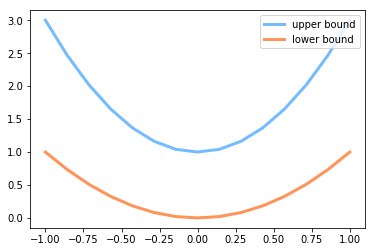

In [4]:
# show our beautiful painting range
plt.plot(PAINT_POINTS[0], 2 * np.power(PAINT_POINTS[0], 2) + 1, c='#74BCFF', lw=3, label='upper bound')
plt.plot(PAINT_POINTS[0], 1 * np.power(PAINT_POINTS[0], 2) + 0, c='#FF9359', lw=3, label='lower bound')
plt.legend(loc='upper right')
plt.show()

In [5]:
def artist_works():     # painting from the famous artist (real target)
    a = np.random.uniform(1, 2, size=BATCH_SIZE)[:, np.newaxis]
    paintings = a * np.power(PAINT_POINTS, 2) + (a-1)
    paintings = torch.from_numpy(paintings).float()
    return Variable(paintings)

G = nn.Sequential(                      # Generator
    nn.Linear(N_IDEAS, 128),            # random ideas (could from normal distribution)
    nn.ReLU(),
    nn.Linear(128, ART_COMPONENTS),     # making a painting from these random ideas
)

D = nn.Sequential(                      # Discriminator
    nn.Linear(ART_COMPONENTS, 128),     # receive art work either from the famous artist or a newbie like G
    nn.ReLU(),
    nn.Linear(128, 1),
    nn.Sigmoid(),                       # tell the probability that the art work is made by artist
)

In [6]:
opt_D = torch.optim.Adam(D.parameters(), lr=LR_D)
opt_G = torch.optim.Adam(G.parameters(), lr=LR_G)

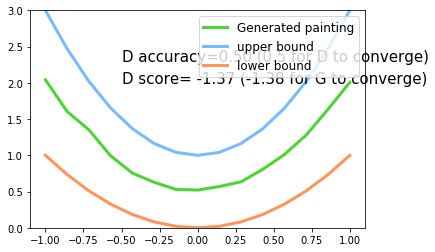

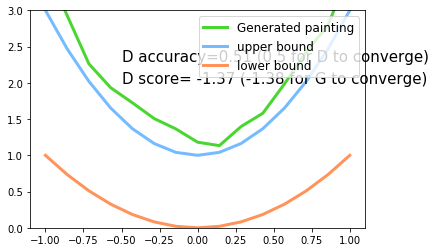

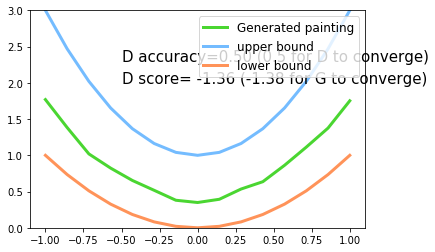

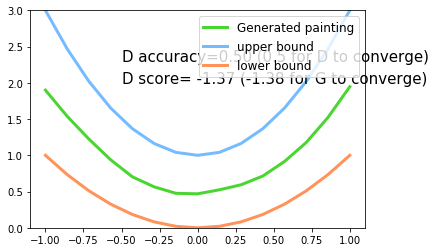

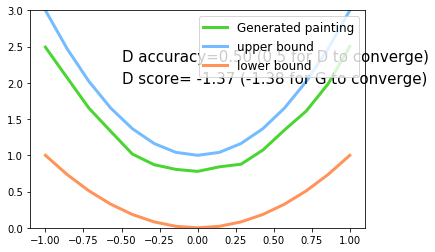

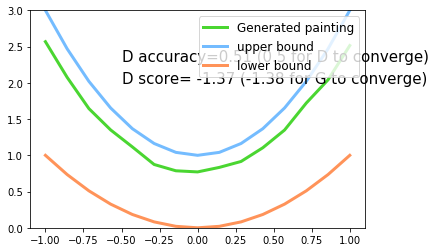

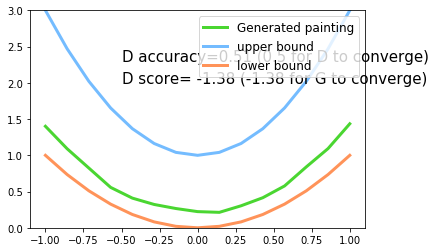

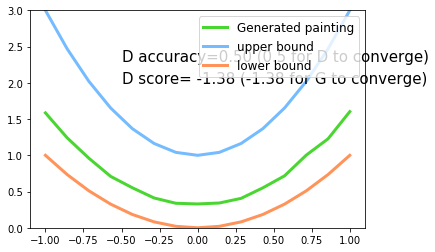

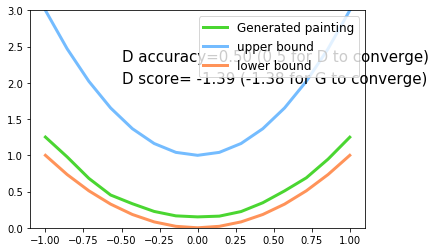

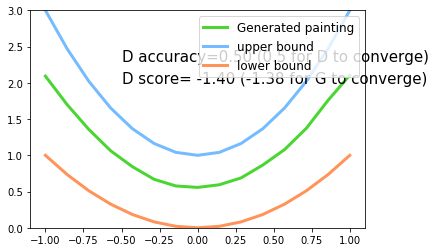

In [9]:
for step in range(10000):
    artist_paintings = artist_works()           # real painting from artist
    G_ideas = Variable(torch.randn(BATCH_SIZE, N_IDEAS))    # random ideas
    G_paintings = G(G_ideas)                    # fake painting from G (random ideas)

    prob_artist0 = D(artist_paintings)          # D try to increase this prob
    prob_artist1 = D(G_paintings)               # D try to reduce this prob

    D_loss = - torch.mean(torch.log(prob_artist0) + torch.log(1. - prob_artist1))
    G_loss = torch.mean(torch.log(1. - prob_artist1))

    opt_D.zero_grad()
    D_loss.backward(retain_variables=True)      # retain_variables for reusing computational graph
    opt_D.step()

    opt_G.zero_grad()
    G_loss.backward()
    opt_G.step()

    if step % 1000 == 0:  # plotting
        plt.cla()
        plt.plot(PAINT_POINTS[0], G_paintings.data.numpy()[0], c='#4AD631', lw=3, label='Generated painting',)
        plt.plot(PAINT_POINTS[0], 2 * np.power(PAINT_POINTS[0], 2) + 1, c='#74BCFF', lw=3, label='upper bound')
        plt.plot(PAINT_POINTS[0], 1 * np.power(PAINT_POINTS[0], 2) + 0, c='#FF9359', lw=3, label='lower bound')
        plt.text(-.5, 2.3, 'D accuracy=%.2f (0.5 for D to converge)' % prob_artist0.data.numpy().mean(), fontdict={'size': 15})
        plt.text(-.5, 2, 'D score= %.2f (-1.38 for G to converge)' % -D_loss.data.numpy(), fontdict={'size': 15})
        plt.ylim((0, 3));plt.legend(loc='upper right', fontsize=12);plt.draw();plt.pause(0.01)
        plt.show()

In [ ]:
# below is for pytorch version => 1.5
# this fix is done by albanD - https://github.com/pytorch/pytorch/issues/39141

for step in range(10000):
    
    artist_paintings = artist_works()           # real painting from artist
    G_ideas = torch.randn(BATCH_SIZE, N_IDEAS, requires_grad=True)  # random ideas
    G_paintings = G(G_ideas)                    # fake painting from G (random ideas)

    prob_artist1 = D(G_paintings)               # D try to reduce this prob
    
    G_loss = torch.mean(torch.log(1. - prob_artist1))  
    opt_G.zero_grad()
    G_loss.backward()
    opt_G.step()
     
    prob_artist0 = D(artist_paintings)          # D try to increase this prob
    prob_artist1 = D(G_paintings.detach())  # D try to reduce this prob
    D_loss = - torch.mean(torch.log(prob_artist0) + torch.log(1. - prob_artist1))      

    opt_D.zero_grad()
    D_loss.backward(retain_graph=True)      # reusing computational graph
    opt_D.step()

    if step % 1000 == 0:  # plotting
        plt.cla()
        plt.plot(PAINT_POINTS[0], G_paintings.data.numpy()[0], c='#4AD631', lw=3, label='Generated painting',)
        plt.plot(PAINT_POINTS[0], 2 * np.power(PAINT_POINTS[0], 2) + 1, c='#74BCFF', lw=3, label='upper bound')
        plt.plot(PAINT_POINTS[0], 1 * np.power(PAINT_POINTS[0], 2) + 0, c='#FF9359', lw=3, label='lower bound')
        plt.text(-.5, 2.3, 'D accuracy=%.2f (0.5 for D to converge)' % prob_artist0.data.numpy().mean(), fontdict={'size': 15})
        plt.text(-.5, 2, 'D score= %.2f (-1.38 for G to converge)' % -D_loss.data.numpy(), fontdict={'size': 15})
        plt.ylim((0, 3));plt.legend(loc='upper right', fontsize=12);plt.draw();plt.pause(0.01)
        plt.show()